## Supervised Learning
## Project: Finding Donors for *CharityML*

## Introduction and Objective 

In this project, several supervised machine learning algorithms have been implemented to accurately model individuals' income using data collected from the 1994 U.S. Census. Then, the best candidate algorithm out of the three tested algorithms from preliminary results have been chosen and further optimized to best model the data. The goal of this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Data Exploration
In the code cell below, the necessary Python libraries and the census data have been loaded. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [ ]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, the following have been computed:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [ ]:
# Total number of records
n_records = len(data)
# other options to do the same:
#n_records = len(data.index)
#n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
#n_greater_50k = len(data[data['income']=='>50K'])   # to find out the sub-dataframe containing only the conditional entries
n_greater_50k = sum(data['income']=='>50K')          # more efficient to use 


# Number of records where individual's income is at most $50,000
n_at_most_50k = sum(data['income'] == '<=50K')

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Data Preparation
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below plots a histogram of these two features.

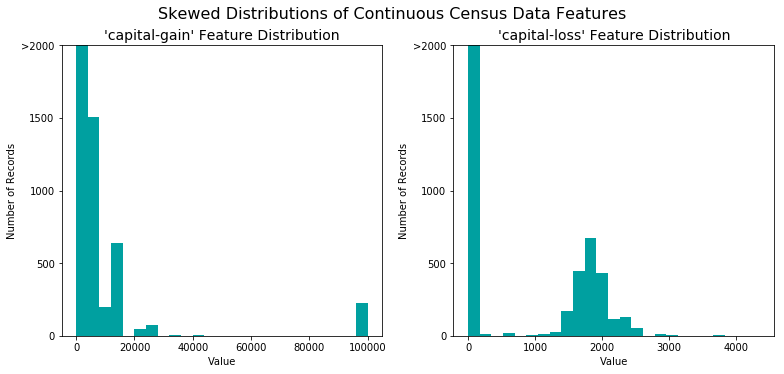

In [ ]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code cell below performs a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

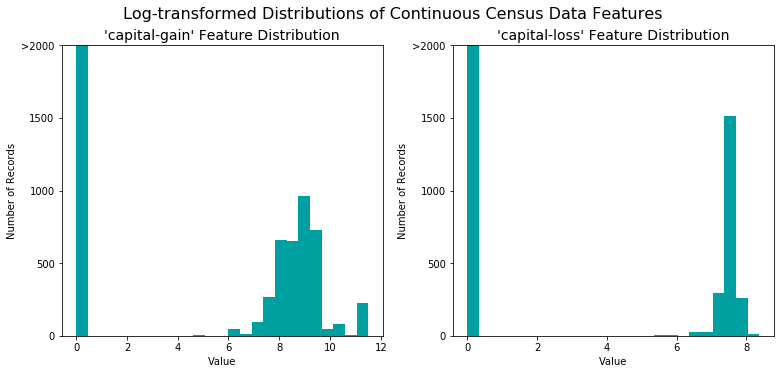

In [ ]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

The code cell below normalizes each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [ ]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) have been used to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - the target label `'income_raw'` have been converted to numerical entries.
   - The records with "<=50K" have been set to `0` and records with ">50K" to `1`.

In [ ]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values

income = pd.DataFrame(data = income_raw)
income['income'] = (income['income'] == '>50K').astype(int)

print("{} people with income <=50K".format(len(income[income['income'] == 0])))
print("{} people with income >50K".format(len(income[income['income'] == 1])))


# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# the following line shows the encoded feature names
print(encoded)

34014 people with income <=50K
11208 people with income >50K
103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code cell below performs this split.

In [ ]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of our choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Definitions of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? The code cell below was used to find that and the results have been assigned to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.
 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [ ]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP)/float(TP+FP+TN+FN)
recall = float(TP)/float(TP + FN)
precision = float(TP)/float(TP + FP)
beta = 0.5

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = float((1 + beta**2) * (precision*recall))/float(((beta**2 * precision)+ recall))

# Print the results 
print("Naive Predictor: Accuracy score: ", accuracy)
print("Naive Predictor: F-score: ", fscore)

print("Naive Predictor: Accuracy score: {:.4f}, F-score: {:.4f}".format(accuracy, fscore))

Naive Predictor: Accuracy score:  0.2478439697492371
Naive Predictor: F-score:  0.29172913543228385
Naive Predictor: Accuracy score: 0.2478, F-score: 0.2917


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application
In this section, we choose three of the supervised learning models above that are appropriate for this problem that we will test on the census data. For each model chosen, We

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?


**Answer: **

#### Model: Logistic Regression
 - one very popular real-world application of logistic regression model is in the domain of credit scoring. A credit-scoring system predicts the likelihood of a borrower to make payments on the borrowed money from the lender.
 - the strengths of logistic regression is that it is simple and interpretable. Also, it can be applied for multi-class predictions. 
 - weaknesses: finds difficulty in modelling complex relationships between the target and the features, can overfit for small and high-dimensional data
 - 1) As this is a classification problem and 2) explainability of a model is very high, 3) efficiency in training given that it is a large dataset (number of features << number of samples), computationally less expensive 
 
 References: 1) https://www.datacamp.com/cheat-sheet/machine-learning-cheat-sheet
 2) https://holypython.com/log-reg/logistic-regression-pros-cons/
 
#### Model: Support Vector Machines (SVM) - Classifier 
  - SVMs are widely used for handwriting recognition and corresponding classification problems.
  - Strengths: relatively memory efficient,less risk of overfitting, the kernel trick can help solve many complex problems
  - Weaknesses: Finding the optimum kernel is time consuming, long training time, difficult to understand 
  - Reasons for selection: helps to detect non-linear decision boundaries, regularization capability
  
 References: https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/

#### Model: Random Forest (Ensemble Technique) classifier 
  - Random forest models are used for customer segmentation applications into various product categories.
  - Strengths: it can automatically handle missing values, reduces overfitting, robust to outliers 
  - Weaknesses: training complexity can be very high, interpretability issues 
  - Reasons for selection: in case the dataset has outliers, it will combat the effect. possibility to better performance due       to the power of handling non-linear parameters effectively.
 
 References: http://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of-random.html#:~:text=Random%20Forest%20is%20based%20on,and%20therefore%20improves%20the%20accuracy.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, I implement the following:
 - Importing `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fitting the learner to the sampled training data and recording the training time.
 - Performing predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Recording the total prediction time.
 - Calculating the accuracy score for both the training subset and testing set.
 - Calculating the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [ ]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time

    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models we've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model we use, if provided.
  - **Note:** We use the default settings for each model — we will tune one specific model in a later section.
- Calculating the number of records equal to 1%, 10%, and 100% of the training data.
  - Storing those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms we have chosen, the following implementation may take some time to run!

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier trained on 36177 samples.


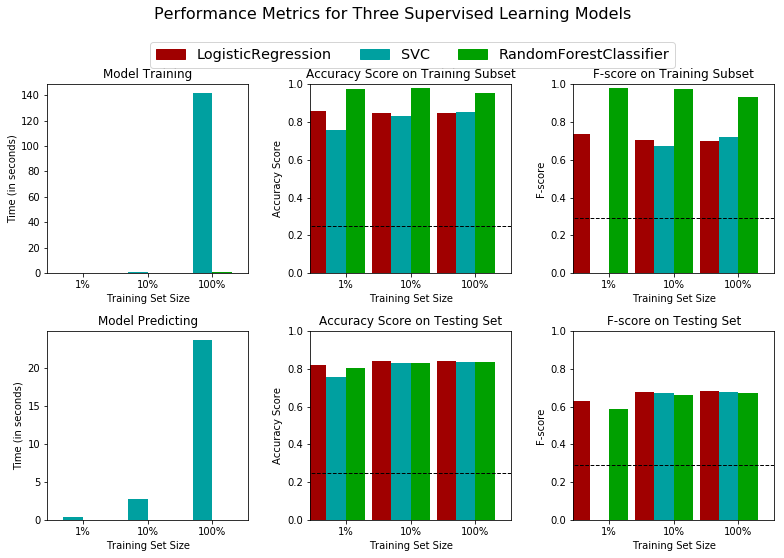

In [ ]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = LogisticRegression(random_state=0)
clf_B = SVC(random_state=0)
clf_C = RandomForestClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100/10)
samples_1 = int(samples_100/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

* Based on the evaluation we performed earlier, we explain to *CharityML* which of the three models we believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 


For this purpose, we look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. We discuss about the following aspects to find out the best model, 
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.


1) Metrics - According to the generated analysis and corresponding visualizations, the F score on the testing for the *Logistic Regression model is the highest*, i.e. around 0.7, when 100% of the training data is used. The Support Vector Classifier and random forest classifiers are respectively close second and third in terms of the same metrics.
2) If we observe the prediction and testing time, then *Logistic regression model is the most computationally efficient option* in comparison to the rest of the models where SVC is the most complex and time consuming model.
3) Hence, from the observations we can see that both in terms of simplicity as well as the model performance in the testing data, *Logistic regression is the best option amongst all the three models*. Also, if we see the learning curve, we can observe a nice convergence between training and testing errors which is desirable.

Therefore, we choose to go ahead with the Logistic regression model which is both extremely fast and produces good prediction for our application.

### Describing the Model in Layman's Terms

* In one to two paragraphs, We explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Here, I describe the major qualities of the model, such as how the model is trained and how the model makes a prediction. We particularly avoid using advanced mathematical jargon, such as describing equations.


The Logistic Regression is an algorithm used for classification of categorical target variables. The concept arises from trying to find the relationships between the variable that we want to predict and the features under consideration. for example, whether or not a candidate wins an election, whether a tumor is malignant or not, etc. can be modelled using this algorithm. 

Major qualities of this model are - 1) it is simple and explainable , 2) it is less prone to overfitting because of the  possibility to implement regularization techniques, 3) it can also be extended for multi-class problems, 4) can be used for both regression and classification problems

The training process includes the application of a special function called logistic function to update the parameter values in the linear relationship equation between dependent and the independent variables. the job of the algorithm is to figure out the best set of parameters through repetitions and re-alignment of the decision boundary that separates the target variable classes in the best possible way in order to find the best model for prediction of future, unknown data. 

Reference: https://medium.com/data-science-group-iitr/logistic-regression-simplified-9b4efe801389

### Implementation: Model Tuning
Here, we fine tune the chosen model. We use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. In the code cell below, I implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier we've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state we have set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [ ]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=0,solver='liblinear')

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

# Here, the parameter under consideration is C parameter (as well as the penalty term), both of which are associated with
# regularization. C is inverse regularization strengh and penalty specifies the degree of punishment for model complexity
parameters = {'penalty': ['l1', 'l2'], 'C': [10.0,1.0,0.1]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6842


### Final Model Evaluation
Here, I try to answer the following questions -

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from our optimized model compare to the naive predictor benchmarks we found earlier?




|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8419       |      0.8420     |
| F-score        |      0.6832       |      0.6842     |

1) Hence, the optimized model's accuracy and F-score on the testing data are respectively 0.8420 and 0.6842.
2) The scores are slightly better than the results of the unoptimized model. 
3) *In comparison with the naive predictor's performance, which is Accuracy score: 0.2478, F-score: 0.2917, the optimized model has far outperformed the naive model.*

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell we fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, we intuitively hypothesize the five features which we  believe to be most important for prediction, and the order in which we would rank them.


1) Occupation: in general, a person's occupation decides her/his salary the most and hence income is directly correlated to this factor.
2) Education: More often than not, education empowers a person to be more valuable to the society and thus have high income.  
3) Sex: Due to the gender discrimination that is prevalent throughout the world, a person's sex can be an important predictor of income. (although it should not be that way.)
4) Age: generally, with increasing age, someone's income increases as well.
5) hours per week: how many hours a person devote to work per week might also determine the level of income.

### Implementation - Extracting Feature Importance
Here, we choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


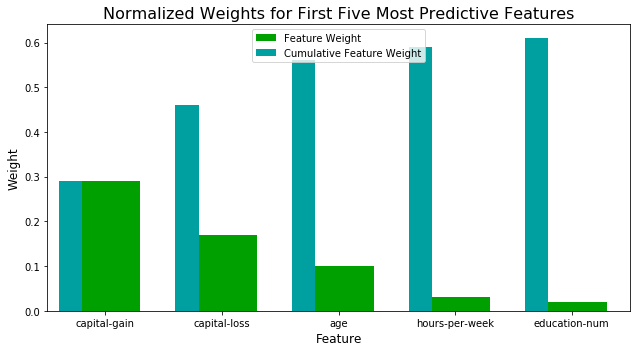

In [ ]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier


# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X_train,y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Here, I observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000 and try to answer the following questions - 
* How do these five features compare to the five features we previously hypothesized?
* how does this visualization confirm the thoughts for the features I had correctly predicted? 
* For the features which are not so close to the model predictions, why do I think these features are more relevant?

**Answer:**

1) In some aspects, the results of the analysis confirms my predictions and some features are newly found insights from the model.
2) The visualization confirms my hypothesis for three different features - age, hours-per-week, and education - although the analysis says that education years number is an even more important factor, the feature "education"(level) which was my hypothesis are closely related with a causal relationship.
3) The two features which I did not predict to be important are actually extremely important factors now that I see in a hindsight. capital loss and gain are those unpredictable features which can literally make a person's income level skyrocket/fall down almost instantly or in a short period of time. Events like promotion,new job,sudden revenue of business, etc. directly reflect itself in terms of capital loss and capital gain.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6842

Final Model trained on reduced data
------
Accuracy on testing data: 0.8051
F-score on testing data: 0.5854


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would I consider using the reduced data as my training set?

**Answer:**  

The final models accuracy score with the important feature sees a dip of approximately 4% in terms of accuracy score. But the more important factor for our imbalanced dataset problem, F-score, sees a huge drop of around 10% when we reduce the feature space.

Even if training time was an important factor, I would not like to compromise with the prediction performance so much by using the reduced data as it might completely fail the goal of prediction (as can be seen from the downfall in F-score) using machine learning technology and bring us closer to the prediction probability of random chance! Moreover, the training time difference between the two is also not very high so as to slow down the decision making process. We can always send the emails to potential donors after a few days rather than sending a huge number of mails to non-donors causing us a huge overhead cost!